# Time Series Forecasting - Multivariable Time Series Models for Stock Market Prediction

## import Packages

In [55]:
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns 
import mysql.connector as mysql
import yfinance as yf


## Change the indicators

In [72]:
#hyperparameters
epochs  = [10,100,1000]
units = [1,2,10]

## Load the Time Series Data use Yahoo finance

In [74]:

start_date = '2017-01-01'

# end_date = '2021-12-31'
# symbol_dataset = 'UNVR.jk'

arr_end_date = ['2021-12-31','2017-12-31', '2017-03-30']
arr_symbol_dataset = ['UNVR.jk', 'GGRM.jk', 'PSDN.jk']

jumlah_pengujian = 0
for index_dataset in arr_symbol_dataset:
    for index_end_date in arr_end_date:
        for epoch in epochs:
            for unit in units: 
                
                jumlah_pengujian+=1
                df = yf.download(index_dataset, start=start_date, end=index_end_date)
                if df.shape[0]>=1250:
                    status_data = " long term"
                elif df.shape[0]>=250:
                    status_data = " mid term"
                else:
                    status_data = " short term"
                
                print("pengujian ke-" + str(jumlah_pengujian))
                print("Data Saham = " + index_dataset + status_data)
                print("Start = " + start_date)
                print("End = " + index_end_date)
                
                print("epochs = " + str(epoch))
                print("unit = " + str(unit))
                
                print("==================================")

        



# # df = yf.download(index_dataset, start=start_date, end=index_end_date)


# # Create a quick overview of the dataset
# df 

[*********************100%***********************]  1 of 1 completed
pengujian ke-1
Data Saham = UNVR.jk long term
Start = 2017-01-01
End = 2021-12-31
epochs = 10
unit = 1
[*********************100%***********************]  1 of 1 completed
pengujian ke-2
Data Saham = UNVR.jk long term
Start = 2017-01-01
End = 2021-12-31
epochs = 10
unit = 2
[*********************100%***********************]  1 of 1 completed
pengujian ke-3
Data Saham = UNVR.jk long term
Start = 2017-01-01
End = 2021-12-31
epochs = 10
unit = 10
[*********************100%***********************]  1 of 1 completed
pengujian ke-4
Data Saham = UNVR.jk long term
Start = 2017-01-01
End = 2021-12-31
epochs = 100
unit = 1
[*********************100%***********************]  1 of 1 completed
pengujian ke-5
Data Saham = UNVR.jk long term
Start = 2017-01-01
End = 2021-12-31
epochs = 100
unit = 2
[*********************100%***********************]  1 of 1 completed
pengujian ke-6
Data Saham = UNVR.jk long term
Start = 2017-01-01
End

[*********************100%***********************]  1 of 1 completed
pengujian ke-40
Data Saham = GGRM.jk mid term
Start = 2017-01-01
End = 2017-12-31
epochs = 100
unit = 1
[*********************100%***********************]  1 of 1 completed
pengujian ke-41
Data Saham = GGRM.jk mid term
Start = 2017-01-01
End = 2017-12-31
epochs = 100
unit = 2
[*********************100%***********************]  1 of 1 completed
pengujian ke-42
Data Saham = GGRM.jk mid term
Start = 2017-01-01
End = 2017-12-31
epochs = 100
unit = 10
[*********************100%***********************]  1 of 1 completed
pengujian ke-43
Data Saham = GGRM.jk mid term
Start = 2017-01-01
End = 2017-12-31
epochs = 1000
unit = 1
[*********************100%***********************]  1 of 1 completed
pengujian ke-44
Data Saham = GGRM.jk mid term
Start = 2017-01-01
End = 2017-12-31
epochs = 1000
unit = 2
[*********************100%***********************]  1 of 1 completed
pengujian ke-45
Data Saham = GGRM.jk mid term
Start = 2017-01-0

[*********************100%***********************]  1 of 1 completed
pengujian ke-79
Data Saham = PSDN.jk short term
Start = 2017-01-01
End = 2017-03-30
epochs = 1000
unit = 1
[*********************100%***********************]  1 of 1 completed
pengujian ke-80
Data Saham = PSDN.jk short term
Start = 2017-01-01
End = 2017-03-30
epochs = 1000
unit = 2
[*********************100%***********************]  1 of 1 completed
pengujian ke-81
Data Saham = PSDN.jk short term
Start = 2017-01-01
End = 2017-03-30
epochs = 1000
unit = 10


In [49]:
liststr_start_date = start_date.split("-")

listint_start_date = [round(float(i)) for i in liststr_start_date]
liststr_start_date

['2017', '01', '01']

# Preprocessing

In [56]:
df.shape[0]

1262

## Cek and Imputation missing value

In [4]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
# jika ada data yang null, run this code
# from sklearn.preprocessing import Imputer
# imp = Imputer(missing_values=0, strategy="mean", axis=0)
# df_imp = imp.fit_transform(df)

## Feature Selection and Scaling

In [6]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# Daftar Fitur yang digunakan
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume']

print('FEATURE LIST')
print([f for f in FEATURES])

# Buat kumpulan data dengan fitur dan filter data ke daftar FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# Kami menambahkan kolom prediksi dan menetapkan nilai dummy untuk menyiapkan data untuk penskalaan
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the dataframe
data_filtered_ext

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


High     Low    Open   Close    Volume  Prediction
Date                                                            
2017-01-02  7760.0  7760.0  7760.0  7760.0         0      7760.0
2017-01-03  7840.0  7760.0  7800.0  7765.0   5014500      7765.0
2017-01-04  8070.0  7770.0  7770.0  8040.0  10642000      8040.0
2017-01-05  8110.0  8005.0  8100.0  8110.0  10493500      8110.0
2017-01-06  8190.0  7965.0  8060.0  8120.0   5400500      8120.0
...            ...     ...     ...     ...       ...         ...
2021-12-24  4210.0  4080.0  4090.0  4200.0  11979500      4200.0
2021-12-27  4230.0  4170.0  4200.0  4210.0   7238100      4210.0
2021-12-28  4230.0  4180.0  4210.0  4180.0   7006900      4180.0
2021-12-29  4190.0  4120.0  4180.0  4120.0   9030700      4120.0
2021-12-30  4170.0  4110.0  4130.0  4110.0   7633100      4110.0

[1262 rows x 6 columns]

In [7]:
# Dapatkan jumlah baris dalam data
nrows = data_filtered.shape[0]
print(nrows)

# Convert the data ke numpy values
np_data_unscaled = np.array(data_filtered)
print(np_data_unscaled)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Membuat scaler terpisah yang berfungsi pada satu kolom untuk prediksi penskalaan
scaler_pred = MinMaxScaler(feature_range=(0,1))
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

1262
[[7.7600e+03 7.7600e+03 7.7600e+03 7.7600e+03 0.0000e+00]
 [7.8400e+03 7.7600e+03 7.8000e+03 7.7650e+03 5.0145e+06]
 [8.0700e+03 7.7700e+03 7.7700e+03 8.0400e+03 1.0642e+07]
 ...
 [4.2300e+03 4.1800e+03 4.2100e+03 4.1800e+03 7.0069e+06]
 [4.1900e+03 4.1200e+03 4.1800e+03 4.1200e+03 9.0307e+06]
 [4.1700e+03 4.1100e+03 4.1300e+03 4.1100e+03 7.6331e+06]]
(1262, 5)


## Transforming the Data

In [8]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 1

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
# print(x_train[1][sequence_length-1][index_Close])
# print(y_train[0])

## Train the Multivariate Prediciton Model

In [9]:
# Configure the neural network model
model = Sequential()
model.add(LSTM(unit, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(Dense(1))


# Compile the model
model.compile(optimizer='adam', loss='mse')

In [10]:
# Training the model
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=16, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/100
64/64 [==============================] - 2s 10ms/step - loss: 0.2871 - val_loss: 0.0093
Epoch 2/100
64/64 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0197
Epoch 3/100
64/64 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0231
Epoch 4/100
64/64 [==============================] - 0s 2ms/step - loss: 0.0015 - val_loss: 0.0220
Epoch 5/100
64/64 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0211
Epoch 6/100
64/64 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0197
Epoch 7/100
64/64 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0186
Epoch 8/100
64/64 [==============================] - 0s 2ms/step - loss: 0.0012 - val_loss: 0.0173
Epoch 9/100
64/64 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0162
Epoch 10/100
64/64 [==============================] - 0s 2ms/step - loss: 0.0010 - val_loss: 0.0152
Epoch 11

64/64 [==============================] - 0s 2ms/step - loss: 4.3449e-04 - val_loss: 0.0028
Epoch 81/100
64/64 [==============================] - 0s 2ms/step - loss: 4.4336e-04 - val_loss: 0.0029
Epoch 82/100
64/64 [==============================] - 0s 2ms/step - loss: 4.4538e-04 - val_loss: 0.0030
Epoch 83/100
64/64 [==============================] - 0s 2ms/step - loss: 4.4532e-04 - val_loss: 0.0029
Epoch 84/100
64/64 [==============================] - 0s 2ms/step - loss: 4.7680e-04 - val_loss: 0.0029
Epoch 85/100
64/64 [==============================] - 0s 2ms/step - loss: 4.2915e-04 - val_loss: 0.0027
Epoch 86/100
64/64 [==============================] - 0s 2ms/step - loss: 4.5111e-04 - val_loss: 0.0026
Epoch 87/100
64/64 [==============================] - 0s 2ms/step - loss: 4.3746e-04 - val_loss: 0.0027
Epoch 88/100
64/64 [==============================] - 0s 2ms/step - loss: 4.3251e-04 - val_loss: 0.0027
Epoch 89/100
64/64 [==============================] - 0s 2ms/step - loss: 4.3

In [11]:
# Plot training & validation loss values
# fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
# sns.lineplot(data=history.history["loss"])
# plt.title("Model loss")
# plt.ylabel("Loss")
# plt.xlabel("Epoch")
# ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
# plt.legend(["Train", "Test"], loc="upper left")
# plt.grid()
# plt.show()

In [12]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

8/8 [==============================] - 0s 1ms/step


In [13]:
# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

In [14]:
print(f'Jumlah data y_pred: {y_pred.shape[0]}')
print(f'Jumlah data y_test_unscaled: {y_test_unscaled.shape[0]}')

Jumlah data y_pred: 252
Jumlah data y_test_unscaled: 252


## Evaluate Model performance

In [76]:
# Root Mean Square Error (RMSE)
MSE = mean_squared_error(y_test_unscaled, y_pred)
RMSE = math.sqrt(MSE)
RMSE = np.round(RMSE, 2)
print(f'Root Mean Square Error (RMSE): {RMSE}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
MAE = np.round(MAE, 2)
print(f'Median Absolute Error (MAE): {MAE}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
MAPE = np.round(MAPE, 2)
print(f'Mean Absolute Percentage Error (MAPE): {MAPE} %')

Root Mean Square Error (RMSE): 368.98
Median Absolute Error (MAE): 308.66
Mean Absolute Percentage Error (MAPE): 6.67 %


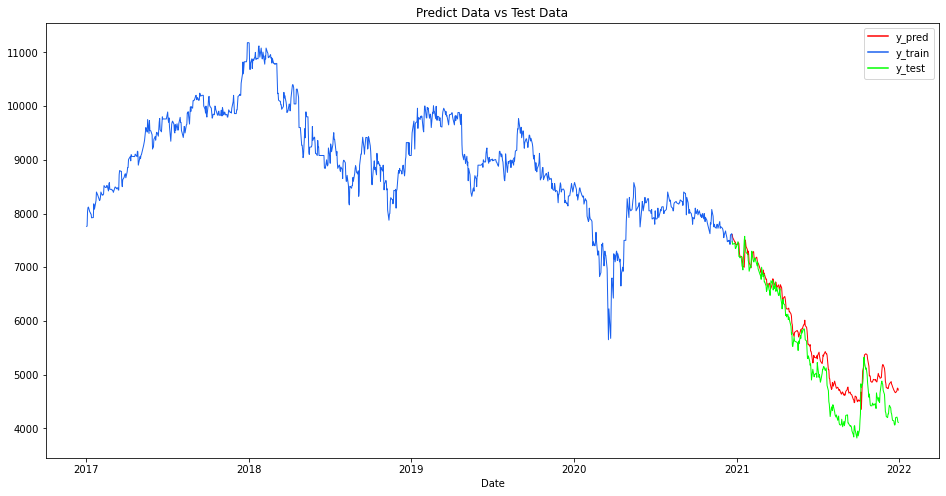

In [18]:
# The date from which on the date is displayed
display_start_date = start_date

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
# valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Predict Data vs Test Data")

sns.set_palette(["#FF0000", "#1960EF", "#00FF00"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
# df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
# ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)

plt.legend()
plt.show()

## Save a new Dataset

In [21]:
#save a new dataset
df_new_data = pd.DataFrame(df_union_zoom)

In [22]:
df_new_data.to_csv('../Datasets/dataset after prediction/'+symbol_dataset
                   +'_LSTM_'+ str(epochs) +'_'+ str(unit) + '.csv', index=False)

In [25]:
read_new_data = pd.read_csv("../Datasets/dataset after prediction/UNVR.jk_LSTM_100_10.csv")
read_new_data

y_train  y_test     y_pred
0      7760.0     NaN        NaN
1      7765.0     NaN        NaN
2      8040.0     NaN        NaN
3      8110.0     NaN        NaN
4      8120.0     NaN        NaN
...       ...     ...        ...
1258      NaN  4200.0  4664.3335
1259      NaN  4210.0  4700.2220
1260      NaN  4180.0  4748.2456
1261      NaN  4120.0  4747.4680
1262      NaN  4110.0  4713.9440

[1263 rows x 3 columns]

## insert to Database

In [38]:
#connect database
mydb = mysql.connect(
    host="localhost",
    user="root",
    password="",
    database="db_tugasakhir"
)
mycursor = mydb.cursor()

#insert to database
sql = "INSERT INTO pengujian_lstm (datasets, start_dates, end_dates,epochs, units, RMSE, MAE, MAPE) VALUES (%s,%s,%s,%s,%s,%s,%s,%s)"
val = (symbol_dataset, start_date, end_date, epochs, unit, RMSE, MAE, MAPE)

mycursor.execute(sql,val)
mydb.commit()